# importing the libraries

First things first we are going to import the necessary libraries:
- pandas - a really nice package to handle data and visualize and edit it
- matplotlib - a data visualization tool
- numpy - a library to edit arrays of numbers specifically, pandas uses this mostly in the background 
- yfinance - an easy solution to download financial data from https://finance.yahoo.com/

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from datetime import datetime
from tqdm import tqdm

# Downloading your first financial data

For this we will be needing three things:
- stockname: the ticker as in yahoo finance, e.g. MSFT, AAPL, BTCUSD=X
- interval: what tick interval do we want? like 5m for OHLCV data in 5 minute buckets, 1h for 1 hour buckets
- - valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
- period: the "lookback" of the data, e.g. 1y is one year back and so on
- - valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max

yfinance downloads the data directly into a pandas dataframe, which you can think of as something similar to an Excel sheet. 

In [3]:
data = yf.download("AAPL",interval="1d",period="3mo")

[*********************100%***********************]  1 of 1 completed


In [4]:
# have a look at the data
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-25,143.070007,145.089996,136.539993,142.919998,142.706757,157611700
2021-01-26,143.600006,144.300003,141.369995,143.160004,142.946396,98390600
2021-01-27,143.429993,144.300003,140.410004,142.059998,141.848038,140843800
2021-01-28,139.520004,141.990005,136.699997,137.089996,136.885452,142621100
2021-01-29,135.830002,136.740005,130.210007,131.960007,131.763107,177180600


## Exploring OHLCV data

So what does Open, High, Low, Close, Adj Close and Volume mean?

The "normal" way stock data is arriving is called tick data, meaning if a trade occurs, the data submitted would contain:
- Symbol
- Timestamp
- Price
- Quantity

E.g. on the 2021-01-25 11:05:12.0021 a trade occured with MSFT at price 101.12 and a quantity of 2 stocks.

Simplified a number of trades could look like this:
- 11:05 MSFT 101.12 2
- 11:05 MSFT 101.11 1
- 11:07 MSFT 101.13 3
- 11:12 MSFT 102.10 5


Now this can be quite confusing for an algorithm, as algorithms love equal time differences, and not inequal ones like in tick data. Therefore the data is aggregated into buckets, which are kind of like statistical summaries of the values in a specific timeframe. E.g. with the above example if divided into 5-minute buckets, the first three trades would be summarized into a bucket, and the last one into the next one (minute 0-4, minute 5-9, minute 10-14, ...).
In terms of OHLCV data (open, high, low, close, volume), this means, that for this bucket, the first and last entry are taken (open and close), the highest one (high), and the lowest one (low).
Volume is the sum of stocks traded, e.g. the sum of the Quantity.

In our example this would mean:

Bucket 11:05-11:09:
- Open (first timestamp) = 101.12
- High Maximum(101.12, 101.11, 101.13) = 101.13
- Low Minimum(101.12, 101.11, 101.13) = 101.11
- Close (last timestamp) = 101.13
- Volume Sum(2, 1, 3, 5) = 11

There is also a python function for this, which you will only need if you are dealing with OHLCV data:

In [13]:
tickdata = [
    # timestamp, stock, price, quantity
    [datetime(2021, 4, 12, 17, 18, 1), "MSFT", 260.22, 2],
    [datetime(2021, 4, 12, 17, 18, 2), "MSFT", 261.22, 9],
    [datetime(2021, 4, 12, 17, 18, 2), "MSFT", 260.23, 22],
    [datetime(2021, 4, 12, 17, 18, 5), "MSFT", 262.22, 2],
    [datetime(2021, 4, 12, 17, 18, 30), "MSFT", 265.22, 200],
]
columnnames = ["timestamp", "stock", "price", "quantity"]
tickdata = pd.DataFrame(tickdata,columns=columnnames)
tickdata = tickdata.set_index("timestamp")
tickdata.head()

,stock,price,quantity
timestamp,,,
2021-04-12 17:18:01,MSFT,260.22,2
2021-04-12 17:18:02,MSFT,261.22,9
2021-04-12 17:18:02,MSFT,260.23,22
2021-04-12 17:18:05,MSFT,262.22,2
2021-04-12 17:18:30,MSFT,265.22,200


In [27]:
data = tickdata['price'].resample('M').ohlc()
data.head()
# TODO

,open,high,low,close
timestamp,,,,
2021-04-30,260.22,265.22,260.22,265.22


# Visualizing our OHLC data



In [29]:
data = yf.download("AAPL",interval="1d",period="3mo")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-25,143.070007,145.089996,136.539993,142.919998,142.706757,157611700
2021-01-26,143.600006,144.300003,141.369995,143.160004,142.946396,98390600
2021-01-27,143.429993,144.300003,140.410004,142.059998,141.848038,140843800
2021-01-28,139.520004,141.990005,136.699997,137.089996,136.885452,142621100
2021-01-29,135.830002,136.740005,130.210007,131.960007,131.763107,177180600


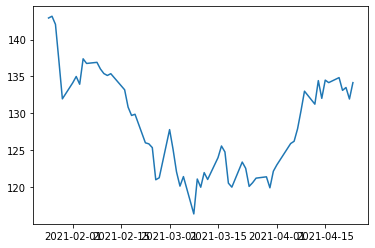

In [30]:
plt.plot(data["Close"])

# our first (stupid) trading logic

Let us take a look at the actions that our bot can take:
- Buy a stock
- Sell a stock
- Hold (do nothing)

To get an understanding let us program a really simple trading logic

In [32]:
startMoney = 10000
crntMoney = startMoney
nrStocks = 0 

# this function symbolizes the buying process of a long stock
def longBuy(crntMoney,nrStocks,crntPrice):
    # get a whole number of how many stocks we can buy with our money
    howMany = int(crntMoney/crntPrice)
    cost = howMany * crntPrice
    # substract that cost from our current Money
    crntMoney -= cost
    # add the nr of stocks we just bought to out nrStocks tracker
    nrStocks += howMany
    return crntMoney,nrStocks

def longSell(crntMoney,nrStocks,crntPrice):
    # pay out the amount of stocks times current Price
    crntMoney += nrStocks * crntPrice
    nrStocks -= nrStocks # we could set it to 0, but we want to symbolize the trade logic
    return crntMoney,nrStocks

Our first logic will be super simple: If the current Price is bigger than yesterday buy or hold (if we already bought a stock), or sell if the price is lower than yesterday

In [44]:
# tqdm is showing us a progress bar, but basically we are just looping through our Close prices in the data array

# reset values
startMoney = 10000
crntMoney = startMoney
nrStocks = 0 

for i,crntPrice in enumerate(data["Close"]):
    if i > 0: # skip the first one as this would crash our "yesterday" logic
        crntHoldings = nrStocks
        yesterday = data["Close"][i-1]
        # start the logic
        if crntPrice > yesterday and crntHoldings == 0:
            # if todays price bigger than yesterday and we have no stocks
            print(data.index[i]," Buying stock for %.2f$" % crntPrice)
            crntMoney,nrStocks = longBuy(crntMoney,nrStocks,crntPrice)
        elif crntPrice > yesterday and crntHoldings != 0:
            # hold because we already purchased stocks!
            pass # do nothing for now
        elif crntPrice < yesterday and crntHoldings > 0:
            # if current Price lower than yesterday and we have stocks in our portfolio
            print(data.index[i]," Selling stock for %.2f$" % crntPrice)
            crntMoney,nrStocks = longSell(crntMoney,nrStocks,crntPrice)
# in the end calculate the value of our portfolio, which is the cash value (crntMoney), and the nrStocks value
portfolioValue = crntMoney + (nrStocks * crntPrice)

print("\n\nYour portfolio value is: %.2f$" % portfolioValue)
earnings = portfolioValue - startMoney
print("Which is a win of: %.2f$" % earnings)

2021-01-26 00:00:00  Buying stock for 143.16$
2021-01-27 00:00:00  Selling stock for 142.06$
2021-02-01 00:00:00  Buying stock for 134.14$
2021-02-03 00:00:00  Selling stock for 133.94$
2021-02-04 00:00:00  Buying stock for 137.39$
2021-02-05 00:00:00  Selling stock for 136.76$
2021-02-08 00:00:00  Buying stock for 136.91$
2021-02-09 00:00:00  Selling stock for 136.01$
2021-02-12 00:00:00  Buying stock for 135.37$
2021-02-16 00:00:00  Selling stock for 133.19$
2021-02-19 00:00:00  Buying stock for 129.87$
2021-02-22 00:00:00  Selling stock for 126.00$
2021-02-26 00:00:00  Buying stock for 121.26$
2021-03-02 00:00:00  Selling stock for 125.12$
2021-03-05 00:00:00  Buying stock for 121.42$
2021-03-08 00:00:00  Selling stock for 116.36$
2021-03-09 00:00:00  Buying stock for 121.09$
2021-03-10 00:00:00  Selling stock for 119.98$
2021-03-11 00:00:00  Buying stock for 121.96$
2021-03-12 00:00:00  Selling stock for 121.03$
2021-03-15 00:00:00  Buying stock for 123.99$
2021-03-17 00:00:00  Sel

# Summary

Now this has just been a really simple approach, and we ignored a lot of errors and mistakes along the way. But this was supposed to be a brief introduction into the topics of writing trading bots. Stay tuned for more!